In [1]:
import numpy as np

In [2]:
from gridworld import GridWorld

,,,,,,
,,,,,,
,,,,,,
,,,,,,
,,,,,,
,,,,,,
,,,,,,

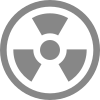
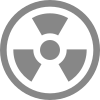
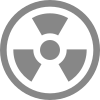
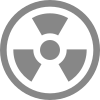
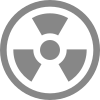
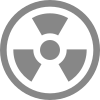
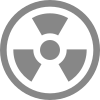
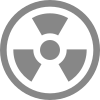
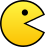
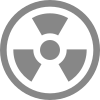
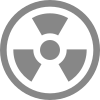
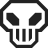
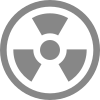
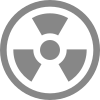
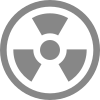
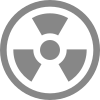
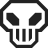
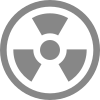
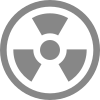
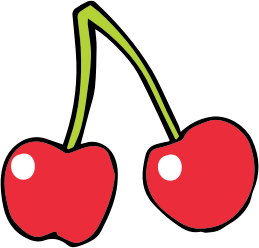
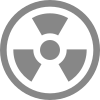
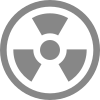
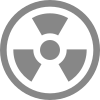
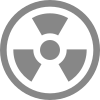
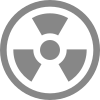
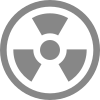
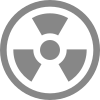
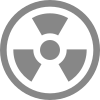

In [3]:
blocks={(1,1), (3,3)}
gw = GridWorld(size=(5,5), start=(0,0), exit=(4,4), blocks=blocks)
gw

In [6]:
from ipywidgets import widgets as W
from IPython.display import display

In [7]:
gw_html = W.HTML(value=gw._repr_html_())

def gw_move(i):
    def func(b=None):
        gw_html.value = gw.move(i)._repr_html_()
    return func

def gw_restart(b=None):
    gw.restart()
    gw_html.value = gw._repr_html_()
buttons = [] 
for i, bn in enumerate(['arrow-right', 'arrow-up', 
                        'arrow-left', 'arrow-down', 'refresh']):
    b = W.Button(icon='fa-'+bn, layout=W.Layout(width='5em'))
    b.on_click(gw_move(i) if i<4 else gw_restart)
    buttons.append(b)

W.HBox([gw_html, W.VBox(buttons)])


### Random player

用隨機玩家玩玩看

In [ ]:
from random import randint
from time import sleep
def random_play(g):
    while True:
        gw_html.value = g._repr_html_()
        sleep(0.1)
        if g.is_end():
            break
        a = randint(0,3)
        g.move(a)
for i in range(10)        :
    gw.restart()
    random_play(gw)

## Reinforcement Learning

* Goals?
* Rewards?
    * at each step $t$, a reward is a number $R_t$
* The goal is to maximizing the total rewards
    * $ G_t = R_{t+1} + R_{t+2} + R_{t+3} + \cdots + R_T $
* 朝三暮四
    * $ G_t = R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + \cdots  $

# Tabular Metod

## State Value

* Policy $\pi$
* $S_t$ is the state at step $t$
* $v_{\pi}(s) = E[G_t | S_t = s] $
* only if we knew what $v_\pi$ is



### Bellman Equation
如果用 $a, r, s'$ 分別代表動作、獎勵、下一步的狀態。那麼

$ v_\pi (s) = \sum_a \pi(a|s) \sum_{s',r} p(s', r'|s , a)(r+\gamma v_k(s') ) $

意思是 $v_\pi (s)$   等於考慮各種可能的動作、和結果後 $r + \gamma v(s')$  的期望值

In [ ]:
gw_html

In [ ]:
# 先全部當成 0
from time import sleep
from random import randint

# 用表格來定義我們的 V 函數
V = np.zeros((gw.size[0]+1, gw.size[1]+1))

        

In [ ]:
from random import randint

# 隨機玩，並且紀錄過程
def random_play(g, gw_html=None):
    history = []
    while True:
        history.append(g.pos)
        if gw_html is not None:
            gw_html.value = g._repr_html_()
            sleep(0.01)
        if g.is_end():
            break
        a = randint(0,3)
        g.move(a)
    return history

α = 0.1
γ = 0.9
gw.V = V
for i in range(1000)        :
    gw.restart()
    history = random_play(gw, gw_html)
    r = gw.score
    v_next = 0
    for pos in reversed(history):
        v = r + γ*v_next
        V[pos] = V[pos] + α * (v-V[pos])
        v_next = v
        r = 0

In [ ]:
# 快速的近似 V 函數

from random import randint
display(gw_html)
α = 0.2
γ = 0.95
gw.V = V
for i in range(1000)        :
    gw.restart()
    gw_html.value = gw._repr_html_()
    history = random_play(gw)        
    r = gw.score
    v_next = 0
    for pos in reversed(history):
        v = r + γ*v_next
        V[pos] = V[pos] + α * (v-V[pos])
        v_next = v
        r = 0


有了 V 函數，看看要如何找到 policy

In [ ]:
def next_pos(pos, d):
    return (pos[0]+abs(d-1)-1, pos[1]+abs(d-2)-1)

def update_max_A(gw):
    if gw.A is None:
        gw.A= -np.ones_like(gw.V)
    for i in range(gw.size[0]):
        for j in range(gw.size[1]):
            gw.A[i,j] = np.argmax([V[next_pos((i,j),a)] for a in range(4)])    
    gw_html.value = gw._repr_html_()
update_max_A(gw)

In [ ]:
# 定義我們的 epsilon greedy
from random import randint, random, shuffle, choice
ϵ = 0.3

def epsilon_greedy(g):
    history = []
    actions = [0,1,2,3]
    while True:
        history.append(g.pos)
        gw_html.value = g._repr_html_()
        sleep(0.03)        
        if g.is_end():
            break
        if random()< ϵ:
            a = choice(actions)
        else:
            a = np.argmax([V[g.next_pos(d)] for d in actions])
        g.move(a)
    return history

α = 0.1
γ = 0.9
gw.V = V
for i in range(100)        :
    gw.restart()
    gw_html.value = gw._repr_html_()
    history = epsilon_greedy(gw)        
    r = gw.score
    v_next = 0
    for pos in reversed(history):
        v = r + γ*v_next
        V[pos] = V[pos] + α * (v-V[pos])
        v_next = v
        r = 0
    update_max_A(gw)

In [ ]:
# 避免掉一些循環的情形
from random import randint, random, shuffle, choice
ϵ = 0.3
V[...] = 0
gw_html = W.HTML()
display(gw_html)
α = 0.1
γ = 0.95
gw.V = V
for i in range(200):
    gw.restart()
    gw_html.value = gw._repr_html_()
    history = epsilon_greedy(gw)       
    r = gw.score
    # 這裡用來紀錄是否更新過
    v_next = 0
    visited = set()
    not_visited = set(history)
    for pos in reversed(history):
        v = r + γ*v_next        
        if pos not in visited:
            V[pos] = V[pos] + α * (v-V[pos])
            not_visited.remove(pos)
            visited.add(pos)
        v_next = V[pos]
        r = 0
    update_max_A(gw)
    # ϵ *=0.99

使用不同的方法更新 `V` 

`V[S] += α*(r+γ*max(V[S'|a] for all a) - V[S])`

In [ ]:
from random import randint, random, shuffle, choice

ϵ = .3
V[...] = 0
gw_html = W.HTML()
display(gw_html)
def random_play(g):
    history = []
    actions = [0,1,2,3]
    while True:
        history.append(g.pos)
        gw_html.value = g._repr_html_()
        sleep(0.01)        
        if g.is_end():
            break
        if random()< ϵ:
            a = choice(actions)
        else:
            a = np.argmax([V[g.next_pos(d)] for d in actions])
        g.move(a)        
    return history


α = 0.1
γ = 0.95
gw.V = V
for i in range(200):
    gw.restart()
    history = random_play(gw)
    r = gw.score
    v_next = 0
    visited = set()
    not_visited = set(history)
    for pos in reversed(history):
        if r == 0:
            npos = [next_pos(pos, a) for a in range(4)]
            vs = [V[p] for p in npos if p not in not_visited]
            vs = [v for v in vs if v!=2]            
            v_next = max(v for v in vs if v!=2)            
        v = r + γ*v_next
        if pos not in visited:
            if V[pos]==2:                  
                V[pos] =  α * v
            else:
                V[pos] = V[pos] + α * (v-V[pos])
            not_visited.remove(pos)
            visited.add(pos)
        v_next = V[pos]
        r = 0
    update_max_A(gw)

In [ ]:
#另外一個可以試試看的 grid world
gw= GridWorld((5,10), (0,0), (0,9))
V = np.zeros((gw.size[0]+2, gw.size[1]+2))

## TD(0)

In [ ]:
# max policy, random, decay, no duplicate update, max(offline)
from random import randint, random, shuffle, choice

gw_html = W.HTML()
display(gw_html)
gw.V = V
gw.V[...] = 0
def TD0(g):
    actions = [0,1,2,3]
    while True:
        #gw_html.value = g._repr_html_()
        if g.is_end():
            break
        sleep(0.02)        
        if random()< ϵ:
            a = choice(actions)
        else:
            a = np.argmax([V[next_pos(g.pos, a)] for a in range(4)])        
        g.move(a)
        r = g.score
        pos = g.pos
        V[pos] += α*(r+γ*max(V[next_pos(pos, a)] for a in range(4)) - V[pos])

α = 0.1
γ = 0.95
ϵ = .3
for i in range(2000):
    gw.restart()
    TD0(gw)         
    update_max_A(gw)
    #ϵ *= 0.99

## Q function

using $ q(s,a) $ instead of $v(s' | a)$

更新方式為 `Q[S][a] += α*(r+γ*Q[S'].max() - Q[S][a])`

In [ ]:
from random import randint, random, shuffle, choice

Q = np.full( (gw.size[0]+2, gw.size[1]+2, 4), 0.)
gw_html = W.HTML()
display(gw_html)

def update_VA(gw, Q):
    if gw.A is None:
        gw.A = np.full( (gw.size[0]+2, gw.size[1]+2), -1)
    if gw.V is None:
        gw.V = np.full( (gw.size[0]+2, gw.size[1]+2), 2.)
    for i in range(gw.size[0]):
        for j in range(gw.size[1]):
            if Q[i,j].min() == 2:
                gw.A[i,j]=-1
                gw.V[i,j]= 2
            else:
                gw.A[i,j] = np.argmax(np.where( Q[i,j] > 1, -2, Q[i,j]))
                gw.V[i,j] = np.max(np.where( Q[i,j] > 1, -2, Q[i,j]))
    gw_html.value = gw._repr_html_()

def Qlearn(g):
    actions = [0,1,2,3]
    while True:
        gw_html.value = g._repr_html_()
        if g.is_end():
            break
        sleep(0.02)        
        if random()< ϵ:
            a = choice(actions)
        else:
            a = np.argmax(Q[g.pos])
        src_pos = g.pos
        g.move(a)    
        dst_pos = g.pos
        r = g.score
        Q[src_pos][a] += α*(r+γ*Q[dst_pos].max() - Q[src_pos][a])

α = 0.1
γ = 0.95
ϵ = .3
for i in range(200):
    gw.restart()
    gw_html.value = gw._repr_html_()
    Qlearn(gw)         
    update_VA(gw, Q)
    #ϵ *= 0.99

### Sarsa

更新方式為
`Q[S][a] += α*(r+γ*Q[S'][a'] - Q[S][a]) `

In [ ]:
# max policy, random, decay, no duplicate update, max(offline)
from random import randint, random, shuffle, choice

Q = np.full( (gw.size[0]+2, gw.size[1]+2, 4), 0.)
gw_html = W.HTML()
display(gw_html)

def update_Qlearn_VA(gw, Q):
    if gw.A is None:
        gw.A = np.full( (gw.size[0]+2, gw.size[1]+2), -1)
    if gw.V is None:
        gw.V = np.full( (gw.size[0]+2, gw.size[1]+2), 2.)
    for i in range(gw.size[0]):
        for j in range(gw.size[1]):
            if Q[i,j].min() == 2:
                gw.A[i,j]=-1
                gw.V[i,j]= 2
            else:
                gw.A[i,j] = np.argmax(np.where( Q[i,j] > 1, -2, Q[i,j]))
                gw.V[i,j] = np.max(np.where( Q[i,j] > 1, -2, Q[i,j]))
    gw_html.value = gw._repr_html_()

def SARSA(g):
    actions = [0,1,2,3]
    prev_a = None
    prev_pos = None
    while True:
        gw_html.value = g._repr_html_()
        if random()< ϵ:
            a = choice(actions)
        else:
            a = np.argmax(Q[g.pos])
        r = g.score
        if prev_a is not None:
            Q[prev_pos][prev_a] += α*(r+γ*Q[g.pos][a] - Q[prev_pos][prev_a])                
        if g.is_end():            
            break
        sleep(0.02)
        prev_pos = g.pos
        g.move(a)
        prev_a = a        

α = 0.1
γ = 0.95
ϵ = .3
for i in range(200):
    gw.restart()
    gw_html.value = gw._repr_html_()
    SARSA(gw)         
    update_Qlearn_VA(gw, Q)
    #ϵ *= 0.99